In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import time    
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
print(f"Torch version= {torch.__version__},\nCuda version={torch.version.cuda}")

Torch version= 1.12.1+cu116,
Cuda version=11.6


In [3]:
df = pd.read_csv("../data/data.csv", converters={#'valid_years_days_dict': eval, 
                                                 'valid_years_list':eval})
df.head()

,weekday_name,month,leap_year_condition,decade,output,output_year_digit,output_year,output_day,valid_years_days_dict,valid_years_list,valid_day_list,decade4,decade100,decade400
0,2,1,0,180,1-1-1800,0,1800,1,"{0: [1, 8, 15, 22, 29], 1: [7, 14, 21, 28], 2:...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1
1,3,1,0,180,1-1-1801,1,1801,1,"{0: [2, 9, 16, 23, 30], 1: [1, 8, 15, 22, 29],...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1
2,4,1,0,180,1-1-1802,2,1802,1,"{0: [3, 10, 17, 24, 31], 1: [2, 9, 16, 23, 30]...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1
3,5,1,0,180,1-1-1803,3,1803,1,"{0: [4, 11, 18, 25], 1: [3, 10, 17, 24, 31], 2...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1
4,6,1,1,180,1-1-1804,4,1804,1,"{4: [1, 8, 15, 22, 29], 8: [3, 10, 17, 24, 31]}","[4, 8, 4, 4, 4, 4, 4, 4]","[1, 8, 15, 22, 29]",0,0,1


**A- training for getting the year**

In [4]:
# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
seed=7        
set_random_seed(seed=seed)

In [5]:
# output_year_digit column is just the last number in the output column
x_year = df[["leap_year_condition", "decade", "decade4", "decade100", "decade400", "valid_years_list", "output_year_digit"]]
y_year = x_year.pop("output_year_digit")
v = x_year.pop("valid_years_list")
v = pd.DataFrame([i for i in v])
# v.head(7), x_year.head(7)

In [6]:
batch_size = 64
xtrain_year, xtest_year, ytrain_year, ytest_year, vtrain_year, vtest_year = train_test_split(x_year, y_year, v, test_size=0.19, shuffle=True, random_state=seed, stratify=x_year["leap_year_condition"])

In [7]:
class CollectedData(Dataset):
    def __init__(self, x, y, v):
        self.data = torch.tensor(x.values.astype(np.float32))
        self.label = torch.tensor(y.values)
        self.valids = torch.tensor(v.values.astype(np.int8))
        self.n_smpl = x.shape[0]
        
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx], self.valids[idx]
    
    def __len__(self):
        return self.n_smpl    

train_set_year = CollectedData(xtrain_year, ytrain_year, vtrain_year)
test_set_year = CollectedData(xtest_year, ytest_year, vtest_year)    

In [8]:
# #replacement for the previous cell
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-int(len(dataset)*0.2), int(len(dataset)*0.2)])

# train_labels_year = torch.tensor(ytrain_year.values.astype(np.float32)) 
# test_labels_year = torch.tensor(ytest_year.values.astype(np.float32)) 
# train_input_year = torch.tensor(xtrain_year.values.astype(np.float32)) 
# test_input_year = torch.tensor(xtest_year.values.astype(np.float32)) 

# train_set_year = TensorDataset(train_input_year, train_labels_year)
# test_set_year = TensorDataset(test_input_year, test_labels_year)


In [9]:
train_loader_year = DataLoader(dataset=train_set_year, shuffle=True, batch_size=batch_size)
test_loader_year = DataLoader(dataset=test_set_year, batch_size=batch_size) 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class network(nn.Module):
    def __init__(self, in_features=5, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 20)
        self.fc2 = nn.Linear(20, 15)
        self.fc3 = nn.Linear(15, out_features) 
        self.initialize_weights()
        
        
    def forward(self, inpt):
        out = F.leaky_relu(self.fc1(inpt))
        out = F.leaky_relu(self.fc2(out))
        out = (self.fc3(out))
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [11]:
# calculating accuracy
@torch.no_grad()
def calculate_accuracy(model, data_loader):
    model.eval()
    
    num_correct = 0
    num_samples = 0

    for data, labels, valids in data_loader:
        
        # transfering data to cuda
        data = data.to(device=device)
        valids = valids.to(device=device)
                
        preds = model(data)
        num_correct += len([1 for pred, vald in zip(preds.argmax(dim=1), valids) if pred in vald])
        num_samples += len(preds)
    accuracy = num_correct/num_samples
    model.train()
    return accuracy  

In [12]:
# initializing the network
model = network(in_features=5, out_features=10).to(device)
lr = 0.001
# loss and optimizer initializing
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

In [13]:
num_epochs = 11

def train_model(num_epochs, data_loader=train_loader_year):
    num_batches = len(data_loader)
    print(f"starting learning rate = {lr} \n number of epochs = {num_epochs} \n number of batches = {num_batches} \n")
    # starting training loop epochs
    result_train_acc, result_test_acc = [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)
        for batch_idx, (data, labels, valids) in progress: 

            # convert data to device
            data = data.to(device=device)
            labels = labels.to(device=device)
            # valids = valids.to(device=device)

            # getting prediction and loss
            preds = model(data)
            loss = criterion(preds, labels)        

            # back propagation
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        train_acc = calculate_accuracy(model, data_loader=train_loader_year)
        test_acc = calculate_accuracy(model, data_loader=test_loader_year)
        schedular.step(test_acc)
        print(f"after {1+epoch} epoch, train_acc = {(train_acc*100):.2f}%, test_acc = {(test_acc*100):.2f}%, time_elapsed = {((time.time()-start_time)/60):.1f} minuts")
        result_train_acc += [train_acc]
        result_test_acc += [test_acc]
    return result_train_acc, result_test_acc
result_train_acc, result_test_acc = train_model(num_epochs, data_loader=train_loader_year)


starting learning rate = 0.001 
 number of epochs = 11 
 number of batches = 1854 



epoch [1/11], loss=2.3461: 100%|██████████████████████████████████████████████████| 1854/1854 [00:17<00:00, 103.90it/s]


after 1 epoch, train_acc = 85.78%, test_acc = 85.65%, time_elapsed = 1.0 minuts


epoch [2/11], loss=1.9848: 100%|██████████████████████████████████████████████████| 1854/1854 [00:13<00:00, 134.64it/s]


after 2 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 0.9 minuts


epoch [3/11], loss=1.7847: 100%|██████████████████████████████████████████████████| 1854/1854 [00:14<00:00, 129.48it/s]


after 3 epoch, train_acc = 98.49%, test_acc = 98.53%, time_elapsed = 0.9 minuts


epoch [4/11], loss=1.8839: 100%|██████████████████████████████████████████████████| 1854/1854 [00:14<00:00, 131.82it/s]


after 4 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 0.9 minuts


epoch [5/11], loss=2.0303: 100%|██████████████████████████████████████████████████| 1854/1854 [00:13<00:00, 133.37it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
after 5 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 0.9 minuts


epoch [6/11], loss=1.7181: 100%|██████████████████████████████████████████████████| 1854/1854 [00:13<00:00, 135.16it/s]


after 6 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 0.9 minuts


epoch [7/11], loss=1.9163: 100%|██████████████████████████████████████████████████| 1854/1854 [00:13<00:00, 137.33it/s]


after 7 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 0.9 minuts


epoch [8/11], loss=1.8527: 100%|██████████████████████████████████████████████████| 1854/1854 [00:13<00:00, 137.86it/s]


after 8 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 0.9 minuts


epoch [9/11], loss=1.8036: 100%|██████████████████████████████████████████████████| 1854/1854 [00:13<00:00, 137.71it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
after 9 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 0.9 minuts


epoch [10/11], loss=1.8046: 100%|█████████████████████████████████████████████████| 1854/1854 [00:13<00:00, 132.61it/s]


after 10 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 0.9 minuts


epoch [11/11], loss=1.8851: 100%|█████████████████████████████████████████████████| 1854/1854 [00:13<00:00, 134.64it/s]


after 11 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 0.9 minuts


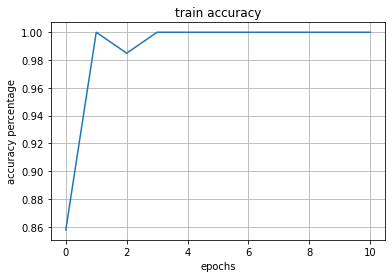

In [14]:
plt.plot(list(range(num_epochs)), result_train_acc)
plt.title("train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.grid()
plt.show()

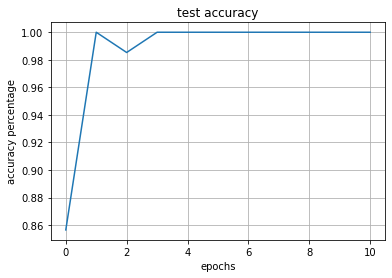

In [15]:
plt.plot(list(range(num_epochs)), result_test_acc)
plt.title("test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.grid()
plt.show()

In [16]:
r_test = xtest_year 
dt = r_test.copy(deep=True) 
r_test = torch.tensor(dt.values.astype(np.float32)).to(device=device)
dt["predicted_year_digit"] = model(r_test).argmax(dim=1).cpu()
dt["predicted_year"] = [str(dec+pred) for dec, pred in zip(dt.decade*10, dt.predicted_year_digit)]
dt.head()

,leap_year_condition,decade,decade4,decade100,decade400,predicted_year_digit,predicted_year
93803,0,217,1,1,1,9,2179
110270,1,219,1,1,1,2,2192
15897,0,205,1,1,1,0,2050
78831,0,203,1,1,1,0,2030
68188,0,181,1,1,1,0,1810


In [20]:
test_accuracy = calculate_accuracy(model, data_loader=test_loader_year)
print(f"test_accuracy = {test_accuracy*100}%")

test_accuracy = 100.0%


**i got accuracy of 90.20% when i used just two columns(decade_year_condition, and decade)**

In [17]:
# # torch.save(model, "../data/year_model_saved")
# model = torch.load("../data/year_model_saved")

In [18]:
dt.to_csv("../data/year_predections.csv", header=True, index=True)